<a href="https://colab.research.google.com/github/otoperalias/Coyuntura/blob/main/clases/Tema3_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tema 3.4. Introducción a la modelización de series. Modelos ARIMA.

In [1]:
# Importamos funciones y establecemos configuración general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# Importamos base de datos:

df = pd.read_excel("https://github.com/otoperalias/Coyuntura/raw/main/clases/datos/ventas.xlsx", index_col=0, parse_dates=True)
df

,ventas
period,
1990-01-01,88000
1990-02-01,84000
1990-03-01,85000
1990-04-01,85000
1990-05-01,84000
...,...
1997-12-01,222000
1998-01-01,228000
1998-02-01,226000


## MODELIZACIÓN DE SERIES.

### 1. Visualización

In [ ]:
# Gráfico serie original
fig,ax=plt.subplots(dpi=75)
ax.plot(df)
ax.set_title('Ventas 1990 - 1998 \n', size=14)
plt.show()

In [ ]:
# Gráfico medias móviles
rol_mean=df.rolling(window=12).mean()
rol_std = df.rolling(window=12).std()

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df, color='blue',label='Original')
ax.plot(rol_mean, color='red', label='Media móvil')
ax.plot(rol_std, color='black', label = 'Desv. estándar móvil')
ax.legend(loc='best')
ax.set_title('Media y desv estándar móviles \n', size=14)
ax.spines['bottom'].set_color('black')
plt.show()

In [ ]:
#Correlogramas
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(8,5))
plot_acf(df.dropna(), ax=ax[0], lags=20)
plot_pacf(df.dropna(), ax=ax[1], lags=20)
plt.show()

### 2. Estacionarizar

#### Tests de Raiz Unitaria

In [ ]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
def DFtest(datos):
    print('Results of Dickey-Fuller Test (H0= NO estac.):')
    dftest = adfuller(datos, autolag='AIC')
    print('Test Statistic', dftest[0])
    print('p-value', dftest[1])
    print('#Lags Used', dftest[2])
    print('# obs', dftest[3])
    for k, v in dftest[4].items():
        print(k,v)
DFtest(df.ventas)

In [ ]:
# KPSS
from statsmodels.tsa.stattools import kpss
def KPSStest(datos):
    print('Results of KPSS Test (H0= Estac.):')
    dftest = kpss((datos), 'ct')
    print("Test statistic = ", dftest[0])
    print("P-value = ", dftest[1])
    print("Critical values :")
    for k, v in dftest[3].items():
        print(k,v)
KPSStest(df.ventas)


#### Estacionarizando

In [ ]:
# Es  útil dibujar un gráfico como este, que combine varias transformaciones en una representación
fig, ax = plt.subplots(3, 2, figsize=(8,8))
# Serie original
ax[0,0].plot(df.ventas)
ax[0,0].set_title('Serie original')
plot_acf(df.ventas, ax=ax[0, 1])
# Primera diferencia
ax[1,0].plot(df.ventas.diff())
ax[1,0].set_title('Primera diferencia')
plot_acf(df.ventas.diff().dropna(), ax=ax[1, 1])
# Segunda diferencia
ax[2,0].plot(df.ventas.diff().diff())
ax[2,0].set_title('Segundas diferencias')
plot_acf(df.ventas.diff().diff().dropna(), ax=ax[2, 1])
plt.subplots_adjust(hspace=0.3)
plt.show()

Para estacionarizar, parece conveniente empezar tomando simplemente primeras diferencias ya que los coeficientes de correlación caen rápidamente. Al tomar diferencias de segundo orden, vemos que el segundo retardo tiene un coeficiente negativo elevado, indicando que la serie podría estar sobre-diferenciada (over differencied).

In [ ]:
# Podemos también comprobar que tomando logaritmos no se mejoran los resultados:
fig, ax=plt.subplots(2,1)
ax[0].plot(np.log(df.ventas).diff())
plot_acf(np.log(df.ventas).diff().dropna(),ax=ax[1])
plt.show()

Comprobamos si la serie es estacionaria con el DFtest:

In [ ]:
#Comprobamos si la serie es estacionaria con el DFtest
DFtest(df.ventas.diff().dropna())
KPSStest(df.ventas.diff().dropna())

Los resultados de los tests nos muestran que está en el límite: estacionariedad débil.  
Por tanto, con las reservas mencionadas, fijamos el orden de diferenciación en uno => d=1.

### 3. Dibujar correlogramas para identificar los parámetros p y q (AR y MA)

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(8,5))
ax[0] = plot_acf(df.ventas.diff().dropna(), ax=ax[0], lags=28)
ax[1] = plot_pacf(df.ventas.diff().dropna(), ax=ax[1], lags=28)
plt.show()

* Componente MA: Vemos en ACF que hay dos retardos bien por encima del nivel de significancia=> q=2.
* Componente AR: El primer retardo el PACF es muy significativo y luego se reduce bastante. Al principio
podemos ser conservadores y establecer p=1.


### 4. Construir el modelo ARIMA

In [ ]:
# Implementamos el método ARIMA usando la función SARIMAX, que es más generalizable.
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# 1,1,2 ARIMA Model (p,d,q=1,1,2)
model = SARIMAX(df.ventas, order=(1,1,2), trend="c")
model_fit = model.fit()
print(model_fit.summary())

Observamos que el coeficiente MA.2 es muy cercano a cero y muy insignificante estadísticamente, por tanto, probamos ahora con ARIMA(1,1,1)

In [ ]:
# 1,1,1 ARIMA Model
model_fit = SARIMAX(df.ventas, trend='c', order=(1,1,1)).fit()
print(model_fit.summary())

* AIC es menor, lo cual es bueno.
* Todos los coeficientes son altamente significativos y con z razonables.
* Ahora representamos los residuos para asegurarnos de que no hay patrones en ellos (o sea, media y varianza constantes)

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid[1:])
fig, ax = plt.subplots(2,2,figsize=(12,5))
residuals.plot(title="Residuos", ax=ax[0,0])
residuals.plot(kind='kde', title='Density', ax=ax[1,0])
plot_acf(residuals, ax=ax[0,1], lags=28)
plot_pacf(residuals, ax=ax[1,1], lags=28)
plt.subplots_adjust(hspace=0.5)
plt.show()

Los residuios parecen correctos con media casi cero y varianza uniforme.


## PREDICCIÓN

### 1. Buscando el modelo óptimo: out-of-sample validation

In [ ]:
# 1. Creamos training y test datasets
train = df.ventas[:85]
test = df.ventas[85:] # 15% de la base de datos

# Creamos un gráfico para visualizarlo
fig,ax=plt.subplots()
ax.plot(train,c="green",label="Training data")
ax.plot(test,c="red",label="Test data")
ax.set_title("División de la serie en training y test datasets")
ax.legend()
plt.show()

In [ ]:
# 2. Construimos el modelo ARIMA(1,1,1)
model_fit = SARIMAX(train, trend='c', order=(1, 1, 1)).fit()

In [ ]:
# 3. Predecimos
pred=model_fit.get_prediction(start='1997-02-01',end='1998-04-01')  # (out of sample forecasts , 95% conf)

In [ ]:
# 4. Convertimos en series de Pandas
fc_series =pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)
lower_series = pred_ci.iloc[:,0] # IC inferior [todas filas, primera columna]
upper_series = pred_ci.iloc[:,1] # IC superior [todas filas, segunda columna]

In [ ]:
# 5. Creamos el gráfico
fig, ax= plt.subplots(figsize=(10,5), dpi=80)
ax.plot(train, label='Training dataset')
ax.plot(test, label='Test dataset')
ax.plot(fc_series, label='Predicción')
ax.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
ax.set_title('Forecast vs Actuals')
ax.legend(loc='upper left', fontsize=12)
plt.show()

* Observamos que el modelo predice mal.
* Para mejorar el modelo, vamos a probar otras alternativas. Por ej., d=2 e iterativamente incrementar p a 5 y entonces q a 5.
* Los criterios para evaluar los modelos son:  
   a) AIC y significatividad de las variables.  
   b) Ver gráficamente la predicción.  
   c) Comparar las medidas de bondad del ajuste respecto a la test dataset, es decir, cuánto se parece la estimación a la test dataset.


In [ ]:
# Construimos el modelo ARIMA(3,2,1) => tras ir probando, este da buen resultado
model_fit = SARIMAX(train,trend='c', order=(3, 2, 1)).fit()
print(model_fit.summary())

In [ ]:
# Predecimos
pred=model_fit.get_prediction(start='1997-02-01',end='1998-04-01')  # (out of sample forecasts )
# Creamos pandas series
fc_series =pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)
lower_series = pred_ci.iloc[:,0]  # IC inferior [todas filas, primer columna]
upper_series = pred_ci.iloc[:,1]  # IC superior [todas filas, segunda columna]
# Dibujamos
fig, ax= plt.subplots(figsize=(10,5), dpi=80)
ax.plot(train, label='Training')
ax.plot(test, label='Actual')
ax.plot(fc_series, label='Predicción')
ax.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
ax.set_title('Forecast vs Actuals')
ax.legend(loc='upper left', fontsize=12)
plt.show()

* AIC más bajo, todo significativo y la predicción es mejor.
* En este caso hemos hecho la predicción al final, pero también se puede hacer para otros periodos.
* Lo mejor es testar y elegir el mejor modelo en base a diferentes predicciones.

#### Medidas para juzgar la bondad o exactitud de la predicción.

In [ ]:
def forecast_accuracy(forecast, actual):
    rmse = np.sqrt(np.mean((forecast-actual)**2))
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'rmse':rmse,'mape':mape,'corr':corr})

In [ ]:
forecast_accuracy(fc_series, test)


Un MAPE de 13.8% indica que el modelo tiene una exactitud del 86.2% prediciendo las 15 observaciones siguientes.

#### Construir el modelo óptimo automáticamente

Una librería más reciente que se puede usar es ```statsforecast```:  
https://nixtlaverse.nixtla.io/statsforecast/index.html

Leer esta guía [QUICK START](https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_short.html).  

Como se indica en el enlace, el *input* de ```StatsForecast``` siempre es un dataframe en formato largo con tres columnas: ```unique_id```, ```ds``` e ```y```.

* La columna ```unique_id``` (*string*, entero o categoría) representa un identificador para la serie.

* La columna ```ds``` (*datestamp*) debe tener un formato compatible con Pandas, idealmente AAAA-MM-DD para una fecha o AAAA-MM-DD HH:MM:SS para una marca de tiempo.

* La columna ```y``` (numérica) representa la medición que se desea predecir.

Dado que la librería no viene pre-instalada en Google Colab, es necesario instalarla cada vez que abrimos una sesión en Google Colab. Esto toma unos segundos.

In [ ]:
pip install statsforecast

In [5]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

In [36]:
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv', parse_dates=['ds'])
df.head()

sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='MS',
)

sf.fit(df)
forecast_df=sf.predict(h=12, level=[95])

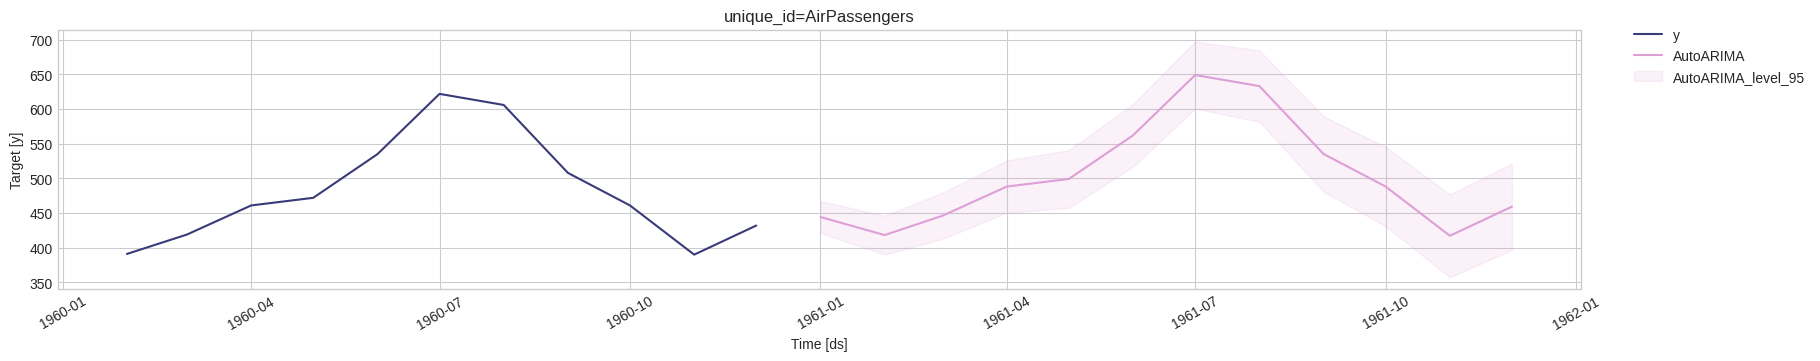

In [37]:
sf.plot(df.loc[df.ds>"1960"], forecast_df, level=[95])

In [38]:
sf.fitted_

array([[AutoARIMA]], dtype=object)

In [39]:
sf.fitted_[0][0].model_

{'coef': {'ar1': np.float64(-0.30957539493920244)},
 'sigma2': np.float64(138.07036741383484),
 'var_coef': array([[0.0062444]]),
 'mask': array([ True]),
 'loglik': np.float64(-508.1971857819979),
 'aic': np.float64(1020.3943715639958),
 'arma': (1, 0, 0, 0, 12, 1, 1),
 'residuals': array([ 6.46632182e-02,  3.35658448e-02,  3.38061466e-02,  2.25518479e-02,
         1.07538668e-02,  2.18258663e-02,  3.07928645e-02,  2.69275400e-02,
         1.25748549e-02, -4.85618739e-03, -1.87467273e-02, -7.77757050e-02,
        -4.26990537e-01,  4.75393684e+00,  2.54787698e+00, -2.69042461e+00,
        -2.92872619e+00,  9.38084921e+00,  1.10957540e+01,  2.47660316e+00,
         9.95328264e-11, -8.00000000e+00, -6.47660316e+00,  1.07616984e+01,
         1.17149047e+01, -3.52339684e+00,  1.11425476e+01, -4.97551987e+00,
         1.62138214e+01, -1.21180675e+01, -5.57235711e+00,  5.68434189e-14,
        -3.00000000e+00,  2.07127382e+00,  3.92872618e+00, -5.07127382e+00,
        -1.85745237e+00,  4.0000